# Random Forest Classifier with CP-Assay and PubChem AID-1030
This Jupyter notebook tried to predict the Pubchem Assay with the AID 1030 using morphological fingerprints from the Cell-Painting assay from Bray et al. Several techniques like SMOTE, Halving Random Search and Nested Cross-Validation are implemented. The Notebook conducts the following steps:
0. Import Modules and define Functions
1. Prepare the Data for Training
2. Train a Random Forest Model with the Data
3. Evaluate Training and Validation of the generated RF-Classifiers

This notebook is part of the master thesis of Luis Vollmers

In [1]:
import math
import rdkit
import sklearn
import numpy as np
import pandas as pd
from numpy import mean
from numpy import interp
from matplotlib import pyplot
from numpy.random import randint
from sklearn.metrics import roc_curve
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

### 0. evaluate_model
this function performs analysis of the outer loop of the nested cross validation procedure. Hence, it takes the predictions of the outer validation set, their corresponding probabilities and their true values into account to calculate metrics like ROC, AUC, Accuracy and so on. It also saves these metrics into graphs and files.

In [2]:
def evaluate_model(outer_true,outer_pred,outer_prob):
    
    # print statement and list elements are appended into single arrays for convenience
    print("\nEvaluation of the Validation Set:\n")
    y_true = np.hstack(outer_true)
    y_pred = np.hstack(outer_pred)
    y_prob = np.vstack(outer_prob)[:,-1]
    
    
    # confusion matrix is printed using built in functions
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)
    
    
    # classification report and other metrics are generated
    print(classification_report(y_true, y_pred))
    print('balanced_acc_score:\t{}\n'.format(balanced_accuracy_score(y_true, y_pred)))
    print('matthews_corr_coef:\t{}\n'.format(matthews_corrcoef(y_true, y_pred)))


    # Sensitivity and specificity are calculated from the confusion matrix and are then printed
    Sensitivity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    Specificity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
    print('Sensitivity:\t{}\n'.format(Sensitivity))
    print('Specificity:\t{}\n'.format(Specificity))

    
    # AUC is calculated from the probabilities and the true y values
    AUC_base_model = roc_auc_score(y_true, y_prob)
    print("AUC-ROC:\t{}\n".format(AUC_base_model))
    
    # calculate and print the ROC from the aggregated (i.e. stacked) outer predictions and plot the graph
    pyplot.figure(1,figsize=(5, 5))    
    FPR, TPR, _ = roc_curve(y_true, y_prob)
    pyplot.xlim([-0.01, 1.01])
    pyplot.ylim([-0.01, 1.01])
    pyplot.plot(FPR, TPR, 'r', label='aggregated ROC')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.savefig("../_output/rf_cp_1030_agg_auc.svg", dpi=300)
    pyplot.show()
    
    # calculate the averaged ROC by iterating over the individuals outer predictions
    pyplot.figure(0,figsize=(5, 5))
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    i = 1
    for _true, _prob in zip(outer_true,outer_prob):
        fpr, tpr, _ = roc_curve(_true, _prob[:, 1])
        # alpha means the opacity of the line
        pyplot.plot(fpr, tpr, 'r', alpha=0.15,label='%s-th Outer fold' % i)
        # interp adjusts the number of datapoints to base_fpr (101)
        tpr = interp(base_fpr, fpr, tpr)
        # setting the first element of tpr 0 adjusts for a possible artifact of interp()
        tpr[0] = 0.0
        tprs.append(tpr)
        i = i + 1
    
    # calculate the standard deviation and thereby the upper and lower limits of the averaged ROC
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    # plot the averaged ROC and output the figure to an svg file
    pyplot.plot(base_fpr, mean_tprs, 'r', label='avr. ROC')
    pyplot.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3, label='STD+-')
    pyplot.xlim([-0.01, 1.01])
    pyplot.ylim([-0.01, 1.01])
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.axes().set_aspect('equal', 'datalim')
    pyplot.title('Averaged AUC-ROC')
    pyplot.legend()
    pyplot.savefig("../_output/rf_cp_1030_avr_auc.svg", dpi=300)
    pyplot.show()
    
    # write the aforementioned metrics into a file
    f = open("../_output/rf_cp_1030_analysis.txt","w+")
    f.write(str(conf_matrix)+'\n')
    f.write(classification_report(y_true, y_pred)+'\n')
    f.write('Balanced Accuracy:\t'+str(balanced_accuracy_score(y_true, y_pred))+'\n')
    f.write('Matthews Coeffici:\t'+str(matthews_corrcoef(y_true, y_pred))+'\n')
    f.write('Sensitivity:\t\t'+str(Sensitivity)+'\n')
    f.write('Specificity:\t\t'+str(Specificity)+'\n')
    f.write('AUC-ROC:\t\t'+str(AUC_base_model)+'\n')
    f.close() 

### 0. evaluate_training
Does exactly the same as evaluate training but does not output the results to a file

In [3]:
def evaluate_training(inner_true,inner_pred,inner_prob):
    
    # print statement and list elements are appended into single arrays for convenience
    print("Evaluation of the Training Set:\n")
    training_true = np.hstack(inner_true)
    training_pred = np.hstack(inner_pred)
    training_prob = np.vstack(inner_prob)


    # confusion matrix is printed using built in functions
    conf_matrix = confusion_matrix(training_true, training_pred)
    print(conf_matrix)


    # calculate and print the ROC from the aggregated (i.e. stacked) inner predictions and plot the graph
    pyplot.figure(3,figsize=(5, 5))
    FPR, TPR, _ = roc_curve(training_true, training_prob[:,1])
    pyplot.plot(FPR, TPR, 'b', label='Base Model')
    pyplot.xlim([-0.01, 1.01])
    pyplot.ylim([-0.01, 1.01])
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title('K-Fold-aggregated AUC-ROC')
    pyplot.legend()
    pyplot.show()

    # calculate the averaged ROC by iterating over the individuals inner predictions
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    pyplot.figure(4,figsize=(5, 5))
    i = 1
    for _true, _prob in zip(inner_true,inner_prob):
        fpr, tpr, _ = roc_curve(_true, _prob[:, 1])
        pyplot.plot(fpr, tpr, 'b', alpha=0.15, label='%s-th outer Fold' % i)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        i = i + 1

    # calculate the standard deviation and thereby the upper and lower limits of the averaged ROC
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    # plot the averaged ROC and output the figure to an svg file
    pyplot.plot(base_fpr, mean_tprs, 'b', label='avr. ROC')
    pyplot.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3, label='STD+-')
    pyplot.xlim([-0.01, 1.01])
    pyplot.ylim([-0.01, 1.01])
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.axes().set_aspect('equal', 'datalim')
    pyplot.title('Averaged AUC-ROC')
    pyplot.legend()
    pyplot.show()

### 1. Prepare the Dataset for Training
- The dataset is read from the second step of the project into RAM
- The second step was conducted to clean the CP Dataframe from erroneous or duplicate entries and for proper calculation of Concentration Medians
- For Prediction only the numerical values from the input columns are necessary
- For SMOTE sampling the parameters should be adjusted to the actual ratios of the minority/majority class
- therefore two variables are calculated that are later inputted into the SMOTE function

In [4]:
# read the dataframe into RAM
df = pd.read_csv('../../02-CorrectingAssays/_output/cp_1030.csv')

# Assign meta_cols which happen to be the first 10 columns and input cols (the rest of the cols)
meta_cols = df.columns[:10]
input_cols = df.columns[10:]

X = np.array(df.loc[:,input_cols])
df['PUBCHEM_ACTIVITY_OUTCOME'] = df['PUBCHEM_ACTIVITY_OUTCOME'].astype('category').cat.codes
y = df['PUBCHEM_ACTIVITY_OUTCOME'].values

# get the number of samples of actives and inactives of the assay
N_1 = df.PUBCHEM_ACTIVITY_OUTCOME.value_counts().to_list()[0]
N_2 = df.PUBCHEM_ACTIVITY_OUTCOME.value_counts().to_list()[1]

# calculate the relative amount of the minority class to majority class for input in the SMOTE function
sampling_prsnt = round(np.exp(-abs(math.log(N_1/N_2))),2)
sampling_smote = 2 * sampling_prsnt

In [5]:
df[input_cols]

,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,259.863281,-12.617188,-2.617188,0.052170,0.035794,0.0,-0.012179,-0.017169,7.737013,8.348186,...,0.028752,-0.141545,-0.091271,-0.123436,-0.234958,-0.261659,-0.269276,0.162881,0.061376,0.104751
1,187.695312,-3.902344,-6.980469,0.054556,0.034720,0.0,-0.012140,-0.011490,4.328814,5.584571,...,-0.046285,-0.177514,-0.196004,-0.227765,-0.182558,-0.212246,-0.204336,0.087412,0.048356,0.082538
2,393.078125,1.277344,-14.460938,0.034487,0.022627,0.0,-0.003674,-0.002242,9.648895,9.643590,...,0.098785,-0.029717,-0.036163,-0.049478,-0.122305,-0.091394,-0.115040,0.200919,0.124473,0.153696
3,277.261719,-22.066406,0.042969,0.021579,0.016727,0.0,-0.010704,0.004419,5.488254,5.403182,...,0.212673,-0.153656,-0.124610,-0.138155,-0.128052,-0.116322,-0.113404,0.232823,0.171553,0.216743
4,330.347656,-7.035156,-0.277344,0.023029,0.014951,0.0,-0.002033,0.009875,6.978576,7.804440,...,0.208695,-0.024429,-0.044756,-0.048945,-0.091941,-0.096263,-0.109370,0.053506,0.038483,0.040109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5016,462.589844,-5.636719,19.992188,0.067275,0.031814,0.0,-0.007301,0.032299,13.229449,12.662835,...,-0.228103,-0.067134,-0.173945,-0.160240,-0.076212,-0.106001,-0.087628,-0.245741,-0.225952,-0.219928
5017,427.277344,3.765625,16.593750,-0.002982,0.000914,0.0,0.001022,0.014122,6.300874,5.039702,...,-0.269482,0.125242,0.082472,0.112903,0.002772,-0.002557,0.013881,-0.390370,-0.302925,-0.305797
5018,-314.781250,6.648438,15.031250,-0.006318,-0.001916,0.0,0.003883,0.054007,-4.368685,-5.161302,...,0.092705,-0.013763,-0.061586,-0.047562,-0.104460,-0.093003,-0.103421,-0.124817,-0.130828,-0.126630
5019,146.511538,-2.757692,-1.307692,0.007432,0.003198,0.0,-0.001657,0.001709,1.137909,0.908320,...,-0.031586,0.058706,0.032472,0.043662,0.006015,0.019518,0.049757,-0.014844,-0.015225,-0.025579


### 2. Train a Random Forest Model with the Data
- For splitting the data into sets used in outer validation a stratified 5-Fold is chosen
- the cell then iterates through 5 different folds
- for every fold X- & y-values for outer validation (test) and inner validation (train) are declared
- for the inner validation a 5 fold CV is performed on the train data
- SMOTE and Randomundersampling are only used if a condition is met, i.e. if the current ratio between min/maj < 0.5
- and if the ratio is less than 75 after oversampling (which should be a separate if cond. only applicable to oversampling not to under and oversampling)
- SMOTE is only used on the inner Dataset so that the outer validation only uses non-synthetic data points
- A parameter grid is searched via halvingrandomCV with 3600 Possible parameter combinations per Fold-Loop from which 500 are sampled
- the best RF-estimator is then fit to the training data
- after fitting the RF-estimator predicts the inner test set first (just for control) and then the outer test set which was not used nor for fitting, neither for hyperparameter optimization.
- for every fold-loop the results are then appended to predefined lists which will be input into the evaluate_* functions

In [83]:
# %%time
# define lists to append the model outputs to
outer_pred = []
outer_true = []
outer_prob = []

inner_pred = []
inner_true = []
inner_prob = []

# starter outer validation Loop
skf = StratifiedKFold(n_splits=5)
print("outer split method:\t{}\n".format(skf))
for train_index, test_index in skf.split(X, y):
    
    # define Datasets, Cross-Validation Metrics and Model-Type
    X_innerCV, X_outerCV = X[train_index], X[test_index]
    y_innerCV, y_outerCV = y[train_index], y[test_index]
    cv = ShuffleSplit(n_splits=5,test_size=0.25, random_state=0)
    rf = RandomForestClassifier(n_jobs=-1)
    
    
    # SMOTE-Sampling is used to over sample the minority class and the majority class is undersampled
    if (sampling_prsnt < 0.5) & (sampling_smote < 0.75):
        over = SMOTE(sampling_strategy=sampling_smote, k_neighbors=30)
        under = RandomUnderSampler(sampling_strategy=0.75)
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)
        X_innerCV, y_innerCV = pipeline.fit_resample(X_innerCV, y_innerCV)
    
    # Hyperparameter tuning with halvingRandomSearchCV
    p_grid = {
            'max_depth': [randint(10,20)],
            'max_features': [randint(40,50)],
            'min_samples_leaf': [5,6,7,8,9,10,11,12,13],
            'min_samples_split': [4,5,6,7,8,9,10,11,12,13],
            'n_estimators':[100, 200, 300, 400, 500],
            'bootstrap': [False,True],
            'oob_score': [False],
            'random_state': [42],para
            'criterion': ['gini', 'entropy'],
            'n_jobs': [-1],
            'class_weight' : [None, 'balanced']
                      }
    rand_search = HalvingRandomSearchCV(estimator=rf, param_distributions=p_grid, factor=3, random_state=42, n_jobs=-1, verbose=0, cv=cv, n_candidates=500)
    rand_search.fit(X_innerCV, y_innerCV)
    print("best sets of parameters:\n{}\n".format(rand_search.best_params_))
    
    
    # use the best estimator and fit it to the DS it was trained on and then predict the DS for outer validation
    clf = rand_search.best_estimator_
    clf.fit(X_innerCV,y_innerCV)
    
    # predict inner Cross-Validation set to checm overfitting
    y_inner_pred = clf.predict(X_innerCV).flatten()
    y_inner_prob = clf.predict_proba(X_innerCV)#[:,1]
    
    # predict outer Cross-Validation set to check for the model performance on unseen data
    y_pred = clf.predict(X_outerCV).flatten()
    y_prob = clf.predict_proba(X_outerCV)#[:,1]
    
    
    # append the inner predictions and the true values to the output-lists
    inner_true.append(y_innerCV)
    inner_pred.append(y_inner_pred)
    inner_prob.append(y_inner_prob)

    # append the outer predictions and the true values to the output-lists
    outer_true.append(y_outerCV)
    outer_pred.append(y_pred)
    outer_prob.append(y_prob)

outer split method:	StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 20
max_resources_: 2986
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 500
n_resources: 20
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
----------
iter: 1
n_candidates: 167
n_resources: 60
Fitting 5 folds for each of 167 candidates, totalling 835 fits
----------
iter: 2
n_candidates: 56
n_resources: 180
Fitting 5 folds for each of 56 candidates, totalling 280 fits
----------
iter: 3
n_candidates: 19
n_resources: 540
Fitting 5 folds for each of 19 candidates, totalling 95 fits
----------
iter: 4
n_candidates: 7
n_resources: 1620
Fitting 5 folds for each of 7 candidates, totalling 35 fits
best sets of parameters:
{'random_state': 42, 'oob_score': False, 'n_jobs': -1, 'n_estimators': 100, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 41, 'max_depth': 10, 'criterion'

### 3. Evaluate Training and Validation of the generated RF-Classifiers 
- first evaluate the Training set and see how well the inner test set was predicted (usually overfitted)
- also calculate balanced acc., Matthews CorrCoeff, and so on
- Do the same for the outer test set that was predicted by the best estimator in the prior step

Evaluation of the Training Set:

[[6397    3]
 [  36 8494]]


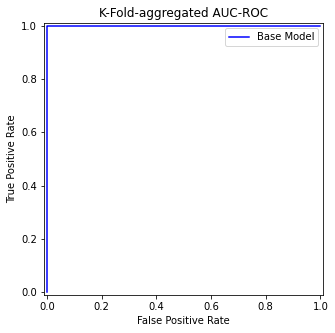

/home/luis/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


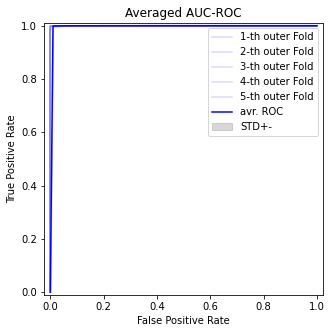


Evaluation of the Validation Set:

[[ 259  550]
 [2025 2187]]
              precision    recall  f1-score   support

           0       0.11      0.32      0.17       809
           1       0.80      0.52      0.63      4212

    accuracy                           0.49      5021
   macro avg       0.46      0.42      0.40      5021
weighted avg       0.69      0.49      0.56      5021

balanced_acc_score:	0.419689550251973

matthews_corr_coef:	-0.11858644427038333

Sensitivity:	0.32014833127317677

Specificity:	0.5192307692307693

AUC-ROC:	0.37394306924591225



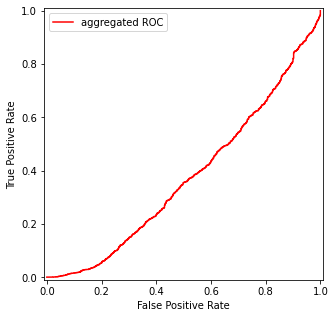

/home/luis/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


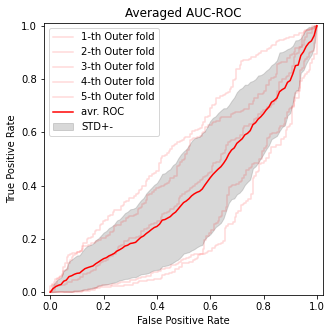

In [84]:
# %%time 

# evaluate the model und the training phase
evaluate_training(inner_true,inner_pred,inner_prob)
evaluate_model(outer_true,outer_pred,outer_prob)

Quellen:
- https://stats.stackexchange.com/questions/186337/average-roc-for-repeated-10-fold-cross-validation-with-probability-estimates
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- http://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
- https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
- https://www.google.com/search?q=nested+cross+validation+sklearn&oq=nested+cross+validation+sklearn&aqs=chrome..69i57j0i22i30l5.17640j1j9&sourceid=chrome&ie=UTF-8